# RNN Model Development

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df=pd.read_csv('/content/gdrive/MyDrive/doge-hist-2y Kopie.csv')

df.rename(columns= {"Unnamed: 0": "Date"}, inplace= True)
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format= True)
df = df.set_index("Date")
df.interpolate(method= "linear", inplace= True)
print(df.shape)
df.head()

(732, 7)


,open,high,low,close,adjclose,volume,ticker
Date,,,,,,,
2019-11-23,0.002145,0.002275,0.002112,0.002273,0.002273,101846258.0,DOGE-EUR
2019-11-24,0.002276,0.002278,0.002085,0.002146,0.002146,92059493.0,DOGE-EUR
2019-11-25,0.002149,0.002151,0.001932,0.002076,0.002076,117692529.0,DOGE-EUR
2019-11-26,0.002077,0.002124,0.002054,0.002078,0.002078,90963851.0,DOGE-EUR
2019-11-27,0.002078,0.002143,0.002025,0.002126,0.002126,91194004.0,DOGE-EUR


In [4]:
df2 = pd.read_csv('/content/gdrive/MyDrive/doge_daily_google_trends_1y.csv')

df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["Dogecoin"]]
df2

,Dogecoin
date,
2020-11-25,100
2020-11-26,39
2020-11-27,31
2020-11-28,31
2020-11-29,33
...,...
2021-11-20,76
2021-11-21,69
2021-11-22,72


In [ ]:
df2.shape

(309, 1)

In [5]:
df_final_doge = df[["high"]].join(df2, how= "outer")

In [6]:
df_final_doge.rename(columns={"Dogecoin": "Google_Trends"}, inplace= True)

In [7]:
df_final_doge.dropna(inplace= True)
df_final_doge['target'] = df_final_doge.high.shift(-1)
df_final_doge = df_final_doge.drop(df_final_doge.index[-1])
df_final_doge

,high,Google_Trends,target
2020-11-25,0.003577,100.0,0.003181
2020-11-26,0.003181,39.0,0.002814
2020-11-27,0.002814,31.0,0.002900
2020-11-28,0.002900,31.0,0.002951
2020-11-29,0.002951,33.0,0.002997
...,...,...,...
2021-11-18,0.212856,78.0,0.209374
2021-11-19,0.209374,83.0,0.209047
2021-11-20,0.209047,76.0,0.206740
2021-11-21,0.206740,69.0,0.201781


In [ ]:
df_final.shape

(308, 2)

In [ ]:
df_final

,high,Google_Trends
2020-11-25,0.003577,100.0
2020-11-26,0.003181,39.0
2020-11-27,0.002814,31.0
2020-11-28,0.002900,31.0
2020-11-29,0.002951,33.0
...,...,...
2021-11-19,0.209374,83.0
2021-11-20,0.209047,76.0
2021-11-21,0.206740,69.0
2021-11-22,0.201781,72.0


# Log-transformation

In [ ]:
df_final["high"] = np.log(df_final["high"])

# Reshaping Data

In [ ]:
## creating train_test_split and scaling values

# instantiating a scaler
scaler = MinMaxScaler()

# selecting relevant column from df
dataset = df_final.values

# splitting into train and test data
split = int(dataset.shape[0]*0.8)

train, test = dataset[:split], dataset[split:]

# scaling the data
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

history_size = 2

# creating arrays X, y for train and test data 
def get_X_y(history_size, dataset):

  X = []
  y = []

  for i in range(history_size, dataset.shape[0]):
    X.append(dataset[i-history_size:i,:])
    y.append(dataset[i,0])

  return np.array(X), np.array(y)


X_train, y_train = get_X_y(history_size, train)
X_test, y_test = get_X_y(history_size, test)

In [ ]:
X_train[0], y_test[0]

(array([[0.06118267, 1.        ],
        [0.03972341, 0.39      ]]), 0.778489654108104)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],2))

In [ ]:
X_train.shape

(244, 2, 2)

In [ ]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],2))

In [ ]:
X_test.shape

(60, 2, 2)

# Modeling

In [ ]:
# instantiating a model
model = Sequential()

# first network layer
model.add(LSTM(units = 100, return_sequences= True, input_shape = (history_size, 2)))
model.add(Dropout(0.2))

# network layer's 2 - 5
#model.add(LSTM(units= 50, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(LSTM(units = 20, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= 50, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= 50, return_sequences= True))
#model.add(Dropout(0.2))
model.add(LSTM(units= 10, return_sequences= False))
model.add(Dropout(0.2))

# network output layer
model.add(Dense(units= 1))

model.compile(optimizer= "rmsprop", loss= "mse")

In [ ]:
model

In [ ]:
es = EarlyStopping(patience = 50, restore_best_weights= True)

model.fit(X_train, 
          y_train,
          validation_split= 0.2,
          epochs = 500,
          batch_size= 32,
          #callbacks= [es],
          verbose= 1)

# Inverse Transform

In [ ]:
def inverse_transformer(y):
  '''takes a one-dimensional input array (y_test or y_hat) and inverse transforms it.'''
  y = np.c_[y, np.ones(len(y))]
  y = scaler.inverse_transform(y)
  y= y[:,0]
  return y

In [ ]:
real_stock_price = inverse_transformer(y_test)

predicted_stock_price = inverse_transformer(model.predict(X_test))

# Inverse Log Transform

In [ ]:
real_stock_price = np.exp(real_stock_price)

predicted_stock_price = np.exp(predicted_stock_price)

# Evaluate

RMSE = 0.020102072468647057


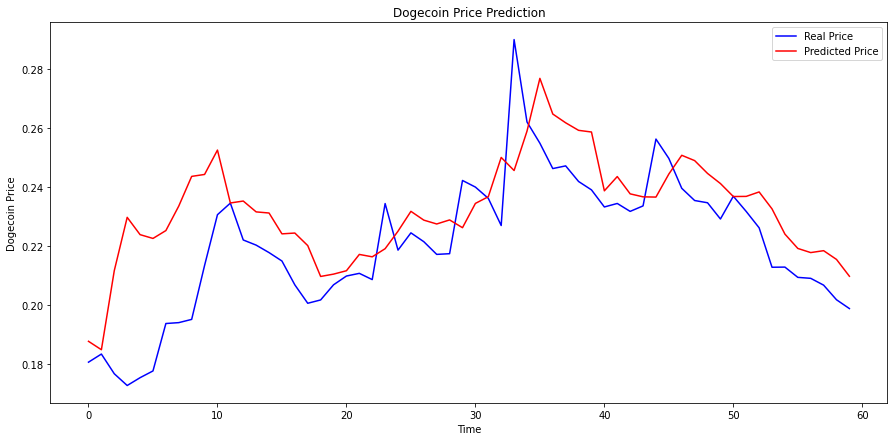

In [ ]:
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

print(f"RMSE = {rmse}")

plt.figure(figsize= (15,7))
plt.plot(real_stock_price, color = 'blue', label = "Real Price")
plt.plot(predicted_stock_price, color = 'red', label = "Predicted Price")
plt.title("Dogecoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Dogecoin Price")
plt.legend()

plt.show()

# Notes on different model performances

In [ ]:
eval_dict = {"optimizer": ["adam","adam","adam","adam","adam","adam","adam","adam","adam", "adam", "rmsprop", "rmsprop"],
             "loss": ["mse","mse","mse","mse","mse","mse","mse","mse","mse", "mse", "mse", "mse"],
              "history_size": [14, 14, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2],
             "epochs": [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
             "layer0": [50,50,50,50,50,50, 50, 50, 50, 50, 50, 100],
            "layer1": [10, 20, 20, 20, 50, 50, 0, 50, 20, 20, 50, 10],
           "layer2": [10, 10, 10, 20, 10, 10, 0, 50, 0, 10, 10, 0],
           "layer3": [0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer4": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer5": [0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0],
            "output": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           "rmse": [0.051, 0.037, 0.017, 0.018, 0.014, 0.021, 0.020, 0.023, np.NaN, 0.023, np.NaN, 0.020]}

eval_df = pd.DataFrame.from_dict(eval_dict)

#for k,v in eval_dict.items():
  #print(f"{k} : {len(v)}")

eval_df

,optimizer,loss,history_size,epochs,layer0,layer1,layer2,layer3,layer4,layer5,output,rmse
0,adam,mse,14,500,50,10,10,0,0,0,1,0.051
1,adam,mse,14,500,50,20,10,0,0,0,1,0.037
2,adam,mse,3,500,50,20,10,0,0,0,1,0.017
3,adam,mse,3,500,50,20,20,10,0,0,1,0.018
4,adam,mse,2,500,50,50,10,0,0,0,1,0.014
5,adam,mse,1,500,50,50,10,0,0,0,1,0.021
6,adam,mse,2,500,50,0,0,0,0,0,1,0.020
7,adam,mse,2,500,50,50,50,0,0,0,1,0.023
8,adam,mse,2,500,50,20,0,0,0,0,1,NaN
9,adam,mse,2,500,50,20,10,0,0,0,1,0.023


# Baseline model
Calculate "dumb" model based on price from previous day to compare our performance to

In [9]:
df_baseline = df_final_doge
df_baseline['last_days_price'] = df_baseline.high.shift(1)
df_baseline = df_baseline.drop(df_baseline.index[0])

baseline_rmse = ((df_baseline.high - df_baseline.last_days_price) ** 2).mean() ** .5

baseline_mse = ((df_baseline.high - df_baseline.last_days_price) ** 2).mean()
#baseline_mse
baseline_rmse

0.02604733229784733

# Samoyedcoin

In [11]:
#import price data for samoyed
df_sa=pd.read_csv('/content/gdrive/MyDrive/samoyed_212.csv')
df_sa.set_index('datetime', inplace=True)
df_sa.interpolate(method= "linear", inplace= True)
df_sa

,timestamp,price,market_caps,total_volumes
datetime,,,,
2021-04-27,1619481600000,0.002110,0.000000e+00,2.975163e+05
2021-04-28,1619568000000,0.002110,0.000000e+00,2.975163e+05
2021-04-29,1619654400000,0.001731,0.000000e+00,2.977700e+05
2021-04-30,1619740800000,0.001566,0.000000e+00,2.528261e+05
2021-05-01,1619827200000,0.001704,0.000000e+00,1.058263e+05
...,...,...,...,...
2021-11-20,1637366400000,0.095379,2.752668e+08,2.176232e+07
2021-11-21,1637452800000,0.103879,3.000463e+08,1.647836e+07
2021-11-22,1637539200000,0.104198,3.014003e+08,1.295468e+07


In [12]:
# import trends data for samoyed
df_sa_gt=pd.read_csv('/content/gdrive/MyDrive/samoyed_gt_daily.csv')
df_sa_gt.set_index('day', inplace=True)
df_sa_gt.interpolate(method= "linear", inplace= True)
df_sa_gt

,Unnamed: 0,Samoyedcoin
day,,
2021-04-27,0,9.916667
2021-04-28,1,36.583333
2021-04-29,2,20.250000
2021-04-30,3,5.333333
2021-05-01,4,9.791667
...,...,...
2021-11-20,152,34.125000
2021-11-21,153,32.875000
2021-11-22,154,29.000000


In [13]:
#merge dfs to have one df w price, gt and target for samoyed
df_final_sa = df_sa[["price"]].join(df_sa_gt[['Samoyedcoin']], how= "outer")
df_final_sa.rename(columns= {"Samoyedcoin": "Google Trends"}, inplace= True)
df_final_sa.dropna(inplace= True)
df_final_sa['target'] = df_final_sa.price.shift(-1) # target is tomorrow's price
df_final_sa = df_final_sa.drop(df_final_sa.index[-1]) # drop last value as it has no target
df_sa.reset_index(inplace=True)
df_final_sa

,price,Google Trends,target
2021-04-27,0.002110,9.916667,0.002110
2021-04-28,0.002110,36.583333,0.001731
2021-04-29,0.001731,20.250000,0.001566
2021-04-30,0.001566,5.333333,0.001704
2021-05-01,0.001704,9.791667,0.002045
...,...,...,...
2021-11-19,0.083764,29.875000,0.095379
2021-11-20,0.095379,34.125000,0.103879
2021-11-21,0.103879,32.875000,0.104198
2021-11-22,0.104198,29.000000,0.086709


In [14]:
# create 2 dfs with only the target to be passed as y into the model
y_sa = df_final_sa[['target']]
y_doge = df_final_doge[['target']]
#y_multi['Dogecoin'] = df_final_doge[['target']]
y_doge

,target
2020-11-25,0.003181
2020-11-26,0.002814
2020-11-27,0.002900
2020-11-28,0.002951
2020-11-29,0.002997
...,...
2021-11-18,0.209374
2021-11-19,0.209047
2021-11-20,0.206740
2021-11-21,0.201781


# Multi-coin, multi-feature model

In [15]:
# creating np-arrays of data to build multi-model

X_multi = [df_final_doge.iloc[:,:2], df_final_sa.iloc[:,:2]]
X_multi = np.array(X_multi, dtype='object')

#X_multi = [np.array(_) for _ in X_multi]

y_multi = [y_doge, y_sa]
y_multi = np.array(y_multi, dtype='object')

#y_multi = [np.array(_) for _ in y_multi]
#y_multi = np.asarray(y_multi).astype('float32')

In [16]:
# padding X and y so they are the same length

X_pad = pad_sequences(X_multi, dtype='float32', padding='post', value=-1)
X_pad = np.asarray(X_pad).astype('float32')
y_pad = pad_sequences(y_multi, dtype='float32', padding='post', value=-1)
y_pad = np.asarray(y_pad).astype('float32')


In [18]:
# check the shapes of x and y, should be n_coins, n_observations, n_features
print(X_pad.shape, y_pad.shape)

(2, 307, 2) (2, 307, 1)


In [19]:
# –– Model
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(307,2)))
model.add(LSTM(units=250, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=25, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

# network output layer
model.add(Dense(units=1))

# –– Compilation
model.compile(optimizer= "rmsprop", loss= "mse")
model

In [20]:
# –– Fit

es = EarlyStopping(patience = 10, restore_best_weights= True)

model.fit(X_pad, y_pad,
          validation_split= 0.2,
          epochs = 100,
          batch_size= 16,
          callbacks = [es],
          verbose= 1)


Epoch 1/100
1/1 [==============================] - 21s 21s/step - loss: 0.0854 - val_loss: 0.8316
Epoch 2/100
1/1 [==============================] - 0s 169ms/step - loss: 1.5687 - val_loss: 0.0057
Epoch 3/100
1/1 [==============================] - 0s 179ms/step - loss: 0.0749 - val_loss: 0.0044
Epoch 4/100
1/1 [==============================] - 0s 168ms/step - loss: 0.0811 - val_loss: 0.0640
Epoch 5/100
1/1 [==============================] - 0s 188ms/step - loss: 0.1196 - val_loss: 0.0140
Epoch 6/100
1/1 [==============================] - 0s 168ms/step - loss: 0.1092 - val_loss: 0.0205
Epoch 7/100
1/1 [==============================] - 0s 181ms/step - loss: 0.0639 - val_loss: 0.0029
Epoch 8/100
1/1 [==============================] - 0s 168ms/step - loss: 0.0560 - val_loss: 0.0066
Epoch 9/100
1/1 [==============================] - 0s 185ms/step - loss: 0.0583 - val_loss: 0.0050
Epoch 10/100
1/1 [==============================] - 0s 167ms/step - loss: 0.0588 - val_loss: 0.0045
Epoch 11/1